# save data

In [7]:
from gradecc.utils.filenames import dir_cache
import pickle

def dump_pkl(obj, fname):
    with open(dir_cache+fname +'.pickle', 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(fname):
    with open(dir_cache+fname +'.pickle', 'rb') as handle:
        return pickle.load(handle)

# dump_pkl(conn_mat, 'conn_mat')
# dump_pkl(conn_mat_centered, 'conn_mat_centered')
# dump_pkl(subject_riemann_mean, 'subject_riemann_mean')
# dump_pkl(grand_mean, 'grand_mean')

conn_mat = load_pkl('conn_mat')
conn_mat_centered = load_pkl('conn_mat_centered')
subject_riemann_mean = load_pkl('subject_riemann_mean')
grand_mean = load_pkl('grand_mean')

In [52]:
# postscript 2 stands for not including `rest` epoch in analysis

# dump_pkl(conn_mat2, 'conn_mat2')
# dump_pkl(conn_mat_centered2, 'conn_mat_centered2')
# dump_pkl(subject_riemann_mean2, 'subject_riemann_mean2')
# dump_pkl(grand_mean2, 'grand_mean2')

conn_mat2 = load_pkl('conn_mat2')
conn_mat_centered2 = load_pkl('conn_mat_centered2')
subject_riemann_mean2 = load_pkl('subject_riemann_mean2')
grand_mean2 = load_pkl('grand_mean2')

# import and load data

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from gradecc.compute.conn_mat import ConnectivityMatrixMean
from gradecc.load_data.subject import SUBJECTS_INT
from gradecc.load_data import Timeseries

import umap
from pyriemann.utils.mean import mean_riemann

from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style='white', context='notebook', rc={'figure.figsize': (7, 5)})

E = ['rest', 'baseline', 'early', 'late']
E2 = ['baseline', 'early', 'late']

In [3]:
se = [[s, e] for s in SUBJECTS_INT for e in E]
se = pd.DataFrame(se, columns=['subject_int', 'epoch'])
se

,subject_int,epoch
0,1,rest
1,1,baseline
2,1,early
3,1,late
4,2,rest
...,...,...
147,45,late
148,46,rest
149,46,baseline
150,46,early


In [4]:
se2 = [[s, e] for s in SUBJECTS_INT for e in E2]
se2 = pd.DataFrame(se2, columns=['subject_int', 'epoch'])

# connectivity matrices

In [5]:
def make_conn_mats(epochs):
    conn_mat = {s: {} for s in SUBJECTS_INT}
    for s in tqdm(SUBJECTS_INT):
        for e in epochs:
            c = ConnectivityMatrixMean(epoch=e, subjects=s, kind='covariance')
            c.load()
            conn_mat[s][e] = c.data
    return conn_mat

In [6]:
conn_mat2 = make_conn_mats(E2)

100%|██████████| 38/38 [00:23<00:00,  1.62it/s]


In [6]:
# for subject s, epoch e
# conn_mat[s][e]

In [9]:
def flat(d: dict):
    d_flat = {s: {} for s in SUBJECTS_INT}
    for s in tqdm(SUBJECTS_INT):
        for e in d[s].keys():
            d_flat[s][e] = d[s][e].flatten()
    return d_flat

conn_mat_flat = flat(conn_mat)
conn_mat_flat2 = flat(conn_mat2)

100%|██████████| 38/38 [00:00<00:00, 42.54it/s]


In [12]:
def stack(mat):
    return np.vstack([
        np.stack([
            mat[s][e]
            for e in mat[s].keys()
        ])
        for s in SUBJECTS_INT
    ])

conn_mat_stacked = stack(conn_mat)
conn_mat_stacked2 = stack(conn_mat2)
conn_mat_stacked2.shape

(114, 1040, 1040)

In [13]:
conn_mat_flat_stacked = stack(conn_mat_flat)
conn_mat_flat_stacked2 = stack(conn_mat_flat2)
conn_mat_flat_stacked.shape

(152, 1081600)

# umap

In [15]:
reducer = umap.UMAP(random_state=42)

In [16]:
embedding = reducer.fit_transform(conn_mat_flat_stacked)
embedding.shape
emb = pd.DataFrame(embedding, columns=['e1', 'e2'])
emb = pd.concat([se, emb], axis=1)

In [45]:
embedding2 = reducer.fit_transform(conn_mat_flat_stacked2)
emb2 = pd.DataFrame(embedding2, columns=['e1', 'e2'])
emb2 = pd.concat([se2, emb2], axis=1)

# plot 2d

<AxesSubplot:xlabel='e1', ylabel='e2'>

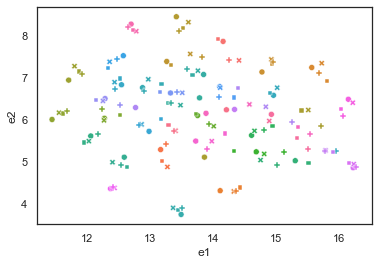

In [17]:
sns.scatterplot(data=emb.astype({'subject_int': str}),
                x='e1', y='e2',
                hue='subject_int', style='epoch',
                legend=False)

# pyriemann centering

In [24]:
all_cmats = conn_mat_stacked
all_cmats2 = conn_mat_stacked2
print(all_cmats.shape)

(152, 1040, 1040)


In [25]:
ts = Timeseries(epoch=E[0], subject_id=SUBJECTS_INT[0])
ts.load()
region_names = ts.region_names
roi_labels = region_names

- should not fill diag with 0 to compute mean riemann

In [31]:
# grand_mean = mean_riemann(all_cmats, maxiter=5)
grand_mean2 = mean_riemann(all_cmats2, maxiter=5)

In [32]:
grand_mean

array([[0.16351544, 0.01311222, 0.01344567, ..., 0.00373861, 0.00201097,
        0.00405588],
       [0.01311222, 0.15676097, 0.0219036 , ..., 0.00552269, 0.00245842,
        0.00541435],
       [0.01344567, 0.0219036 , 0.1605061 , ..., 0.0054473 , 0.00234032,
        0.00483201],
       ...,
       [0.00373861, 0.00552269, 0.0054473 , ..., 0.52021354, 0.06646739,
        0.13679602],
       [0.00201097, 0.00245842, 0.00234032, ..., 0.06646739, 0.53588015,
        0.05557587],
       [0.00405588, 0.00541435, 0.00483201, ..., 0.13679602, 0.05557587,
        0.51904623]])

In [33]:
grand_mean2

array([[0.16378138, 0.01275667, 0.0134736 , ..., 0.00386107, 0.00217978,
        0.00450187],
       [0.01275667, 0.15615674, 0.0224449 , ..., 0.00591451, 0.00255782,
        0.00573476],
       [0.0134736 , 0.0224449 , 0.16030768, ..., 0.00596199, 0.00261473,
        0.00506538],
       ...,
       [0.00386107, 0.00591451, 0.00596199, ..., 0.51607051, 0.06587699,
        0.14030197],
       [0.00217978, 0.00255782, 0.00261473, ..., 0.06587699, 0.5348349 ,
        0.05112269],
       [0.00450187, 0.00573476, 0.00506538, ..., 0.14030197, 0.05112269,
        0.51443634]])

In [29]:
# save grand_mean
df = pd.DataFrame(grand_mean, index=roi_labels, columns=roi_labels)
df.to_csv('grand_mean.tsv', sep='\t')

In [34]:
# save grand_mean
df = pd.DataFrame(grand_mean2, index=roi_labels, columns=roi_labels)
df.to_csv('grand_mean2.tsv', sep='\t')

In [35]:
def make_subj_r_mean(conn_mat):
    subject_riemann_mean = {}
    for s in tqdm(SUBJECTS_INT):
        subject_riemann_mean[s] = mean_riemann(np.stack(conn_mat[s].values()), maxiter=10)
    return subject_riemann_mean

subject_riemann_mean2 = make_subj_r_mean(conn_mat2)

100%|██████████| 38/38 [14:30<00:00, 22.91s/it]


In [36]:
# https://github.com/danjgale/adaptation-manifolds/blob/main/adaptman/connectivity.py

from pyriemann.utils.base import sqrtm, logm, expm, invsqrtm

def center_cmat(c, sub_mean, grand_mean):
    """Center covariance matrix using tangent transporting procedure

    Parameters
    ----------
    c : numpy.ndarray
        Single MxM covariance matrix of a single subject
    sub_mean : numpy.ndarray
        Geometric mean covariance matrix of the subject
    grand_mean : numpy.ndarray
        Geometric mean across all subjects and matrices

    Returns
    -------
    numpy.ndarray
        Centered covariance matrix
    """
    t = _to_tangent(c, sub_mean)
    tc = _gl_transport(t, sub_mean, grand_mean)
    return _from_tangent(tc, grand_mean)


# Covariance centering
def _to_tangent(s, mean):
    p = sqrtm(mean)
    p_inv = invsqrtm(mean)
    return p @ logm(p_inv @ s @ p_inv) @ p


def _gl_transport(t, sub_mean, grand_mean):
    g = sqrtm(grand_mean) @ invsqrtm(sub_mean)
    return g @ t @ g.T


def _from_tangent(t, grand_mean):
    p = sqrtm(grand_mean)
    p_inv = invsqrtm(grand_mean)
    return p @ expm(p_inv @ t @ p_inv) @ p


In [37]:
def make_conn_mat_cen(conn_mat):
    conn_mat_centered = {}
    for s in tqdm(SUBJECTS_INT):
        conn_mat_centered[s] = {
            e: center_cmat(conn_mat[s][e], subject_riemann_mean[s], grand_mean)
            for e in conn_mat[s].keys()
        }
    return conn_mat_centered

conn_mat_centered2 = make_conn_mat_cen(conn_mat2)

100%|██████████| 38/38 [06:25<00:00, 10.14s/it]


In [40]:
print(conn_mat_centered[1]['early'].shape)
print(conn_mat[1]['early'].shape)

(1040, 1040)
(1040, 1040)


In [42]:
conn_mat_centered_flat = flat(conn_mat_centered)
conn_mat_centered_flat2 = flat(conn_mat_centered2)

100%|██████████| 38/38 [00:00<00:00, 44.83it/s]


In [ ]:
# umap centered
reducer = umap.UMAP(random_state=42)
embedding_cen = reducer.fit_transform(stack(conn_mat_centered_flat))
print(embedding_cen.shape)
emb_cen = pd.DataFrame(embedding_cen, columns=['e1', 'e2'])
emb_cen = pd.concat([se, emb_cen], axis=1)

In [46]:
reducer = umap.UMAP(random_state=42)
embedding_cen2 = reducer.fit_transform(stack(conn_mat_centered_flat2))
print(embedding_cen2.shape)
emb_cen2 = pd.DataFrame(embedding_cen2, columns=['e1', 'e2'])
emb_cen2 = pd.concat([se, emb_cen2], axis=1)

(152, 2)
(152, 2)
(114, 2)


# chart plots

Text(0.5, 1.0, 'centered - NO rest included')

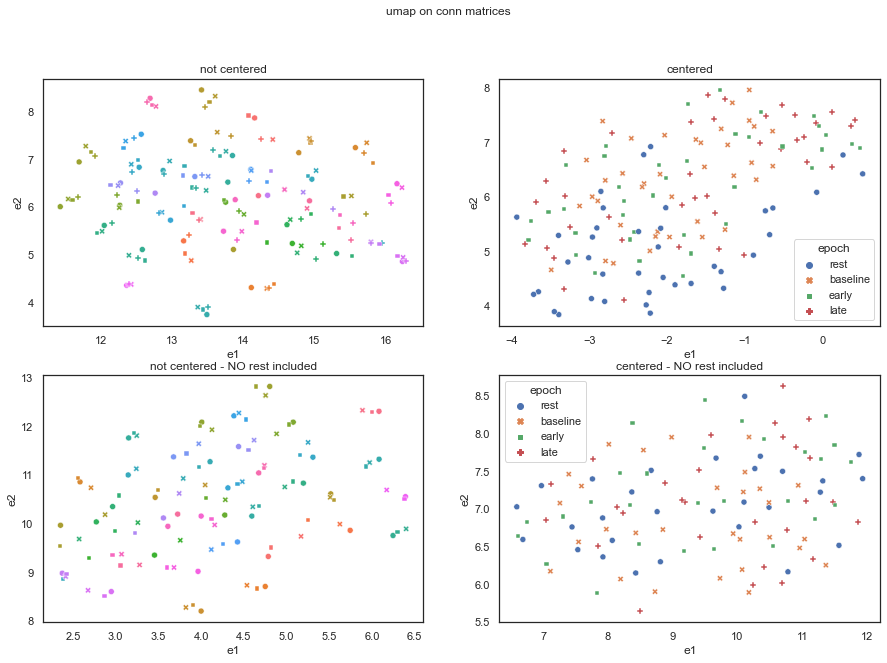

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10),
                         # sharey=True, sharex=True
                         )
fig.suptitle('umap on conn matrices')

sns.scatterplot(data=emb.astype({'subject_int': str}),
                x='e1', y='e2',
                hue='subject_int',
                style='epoch',
                legend=False,
                ax=axes[0, 0],
                )
axes[0, 0].set_title('not centered')

sns.scatterplot(data=emb_cen.astype({'subject_int': str}),
                x='e1', y='e2',
                style='epoch',
                hue='epoch',
                # legend=False,
                ax=axes[0, 1],
                )
axes[0, 1].set_title('centered')


sns.scatterplot(data=emb2.astype({'subject_int': str}),
                x='e1', y='e2',
                hue='subject_int',
                style='epoch',
                legend=False,
                ax=axes[1, 0],
                )
axes[1, 0].set_title('not centered - NO rest included')

sns.scatterplot(data=emb_cen2.astype({'subject_int': str}),
                x='e1', y='e2',
                style='epoch',
                hue='epoch',
                # legend=False,
                ax=axes[1, 1],
                )
axes[1, 1].set_title('centered - NO rest included')